In [1]:
import urllib.request
import bs4
from bs4 import BeautifulSoup
import re
import json
from subprocess import check_output
import pandas as pd
from datetime import datetime

In [2]:
models = ["modely"]

In [3]:
url = "https://www.tesla.com/modely/design#overview"

In [4]:
def downloadTeslaModelPage(url):
    response = urllib.request.urlopen(url)
    html = response.read().decode()
    soup = bs4.BeautifulSoup(html)
    return soup

In [5]:
def getTeslaModelJSON(soup_page):
    script = soup_page.find('script', text=re.compile(r'dataJson'))
    matches = re.finditer(r'const\s*\w*\s*=\s*\{.+?\};', script.text, re.DOTALL)
    dict_matches = [re.sub(r'const\s*\w*\s*=\s*', '', match.group(0)).rstrip(";") for match in matches]
    concat_dicts = ",".join(dict_matches)
    js_export_json_string = 'const teslaData = [' + concat_dicts + '];\nprocess.stdout.write(JSON.stringify(teslaData));'
    with open('temp.js', 'w') as f:
        f.write(js_export_json_string)
    modelData = json.loads(check_output(['node','temp.js']).decode())
    with open('tesla_modely.json', 'w') as f:
        json.dump(modelData, f)

In [271]:
###

In [279]:
german_modely_page = downloadTeslaModelPage(de_url)

In [280]:
getTeslaModelJSON(german_modely_page)

In [281]:
gerModelYJSON = json.loads(importModelJSON("tesla_modely.json"))

In [282]:
gerModelYJSON

[{'DSServices': {'date': 1672996575008,
   'KeyManager': {'keys': {'Lexicon': [{'key': 'Lexicon.m3',
       'query': {'available_configurations': 'm3:m3',
        'language': 'de',
        'market': 'DE',
        'app': 'find-my-tesla',
        'isTcoEnabled': '1',
        'tags': '',
        'context': '',
        'version': 'redesign',
        'seekret': '',
        'isFinplatEnabled': '0',
        'isWechatMiniProgramEnv': '0',
        'isWechatBrowserEnv': '0',
        'isFeeSvcEnabled': '0',
        'model': 'm3',
        'variant': 'm3'}}],
     'Incentives': [{'key': 'Incentives.m3.m3',
       'query': {'available_configurations': 'm3:m3',
        'language': 'de',
        'market': 'DE',
        'app': 'find-my-tesla',
        'isTcoEnabled': '1',
        'tags': '',
        'context': '',
        'version': 'redesign',
        'seekret': '',
        'isFinplatEnabled': '0',
        'isWechatMiniProgramEnv': '0',
        'isWechatBrowserEnv': '0',
        'isFeeSvcEnabled': '0'

In [272]:
###

In [6]:
modely_page = downloadTeslaModelPage(url)

In [7]:
getTeslaModelJSON(modely_page)

In [8]:
def importModelJSON(json_file):
    with open(json_file, 'r') as f:
        return f.read()

In [9]:
###

In [9]:
modelyJSON = json.loads(importModelJSON("tesla_modely.json"))

In [11]:
###

## Get Vehicle Information
- Get base price for "Model Y Long Range" (65990)
- Get Est. Delivery in same format as on webpage (Jan - Mar 2023)
- Get available information: Range, Top Speed, Acceleration
- Get all available trims (Long Range + Performance
)
- Get all Options with prices: (color, wheels, tow hitch, interior, seats, enhaced Autopilot, FSD, charging: wall connector + mobile connector)

In [10]:
def getLexicon(modelJSON):
    try:
        return modelJSON[0]["DSServices"]["Lexicon.my"]
    except:
        return "No such Lexicon exists"
    
lexicon = getLexicon(modelyJSON)

In [11]:
def getAllTrims(modelJSON):
    trims = modelyJSON[0]["DSServices"]["Lexicon.my"]["sku"]["trims"]
    return trims

def getConfigurableTrims(modelJSON):
    """Scrapes the JSON scraped from the Tesla webpage and returns a dictionary of all configurable trims with corresponding options"""
    all_trims = getAllTrims(modelJSON)
    configurable_trims = {k: v for k, v in all_trims.items() if "configurator" in v}
    return configurable_trims


def explainConfigurableTrims(configurable_trims):
    """Takes the trims dictionary and returns a dictionary with the shortcut and the corresponding name"""
    new_dict = {}
    for key, value in configurable_trims.items():
        new_dict[key] = value["variant"]["name"]
    
    return new_dict

def explainTrim(trim):
    """Takes the shortcut of one trim and returns the name/description of the trim"""
    try:
        return configurable_trims[trim]["variant"]["name"]
    except:
        print("There is no trim available with the shortcut " + trim)

In [12]:
configurable_trims = getConfigurableTrims(modelyJSON)

In [13]:
available_trims = list(configurable_trims.keys())

In [14]:
available_trims

['$MTY05', '$MTY11']

## OPTIONS of the Model

In [15]:
# All available options
def getModelOptions(modelJSON):
    return modelJSON[0]["DSServices"]["Lexicon.my"]["options"]

options = getModelOptions(modelyJSON)

In [129]:
def getPricedOptions(options):
    """Takes the options object/dict as input and return a dictionary with the options and their correpsonding pricing"""
    new_dict = {}
    important_values = ["name", "price", "pricing"]
    result = {key: {k: v for k, v in value.items() if k in important_values} for key, value in options.items()}
    return result

pricedOptions = getPricedOptions(options)

In [17]:
def optionsCodeWithExplanation(options):
    new_dict = {}
    for key, value in options.items():
        new_dict[key] = value["name"]
        
    return new_dict


def explainThisOption(option):
    """Returns the name/description of the prompted option"""
    explanation = ""
    if "$" in option:
        explanation = explainedOptions[option]
    else:
        explanation = explainedOptions["$" + option]
    return explanation

explainedOptions = optionsCodeWithExplanation(options)


In [18]:
explainThisOption("SPTY1")

'Performance Upgrade'

### Get base price for "Model Y Long Range" (65990)


In [19]:
def getPriceForTrim(trim):
    """Takes in the options JSON and the trim shortcut in teh format '$XXXX' and returns the price for that trim"""
    price = 0
    for jsonObj in options[trim]["pricing"]:
        if jsonObj["type"] == "base_plus_trim":
            price = jsonObj["value"]
    return price

getPriceForTrim("$MTY05")

69990

In [20]:
def pricesForTrims(available_trims):
    """Takes in the list of available trims and returns a dict with country code, model, trim, price and currency"""
    trim_price_infos = []
    for trim in available_trims:
        for jsonObj in options[trim]["pricing"]:
            if jsonObj["type"] == "base_plus_trim":
                trim_price_infos.append({
                    "country code": lexicon["market"],
                    "model": lexicon["product"],
                    "trim": explainTrim(trim),
                    "shortcut": trim,
                    "price": jsonObj["value"],
                    "currency": jsonObj["context"]
                })
    return trim_price_infos

pricesForTrims(available_trims)

[{'country code': 'US',
  'model': 'my',
  'trim': 'PERFORMANCE',
  'shortcut': '$MTY05',
  'price': 69990,
  'currency': 'USD'},
 {'country code': 'US',
  'model': 'my',
  'trim': 'LONG RANGE ALL-WHEEL DRIVE',
  'shortcut': '$MTY11',
  'price': 65990,
  'currency': 'USD'}]

### Get Est. Delivery in same format as on webpage (Jan - Mar 2023)

In [21]:
eddData = modelyJSON[1]["eddData"]

In [22]:
pd.DataFrame(eddData)

,id,deliveryWindowDisplay,children,childIds,countryCode,region,model,options,atDate,inStart,inEnd,inType,effectiveStartDate
0,372325,None,"[{'id': 1339, 'name': 'MY 3rd Row Seating_+1 M...",[1339],US,west,my,[$MTY11],None,01/01/2023 00:00:00,03/01/2023 00:00:00,month_year,2023-01-04T08:00:00
1,372318,None,"[{'id': 1339, 'name': 'MY 3rd Row Seating_+1 M...",[1339],US,texas,my,[$MTY11],None,01/01/2023 00:00:00,03/01/2023 00:00:00,month_year,2023-01-04T08:00:00
2,372339,None,"[{'id': 1339, 'name': 'MY 3rd Row Seating_+1 M...",[1339],US,other,my,[$MTY11],None,01/01/2023 00:00:00,03/01/2023 00:00:00,month_year,2023-01-04T08:00:00
3,372332,None,"[{'id': 1339, 'name': 'MY 3rd Row Seating_+1 M...",[1339],US,noncontinental(ak/hi),my,[$MTY11],None,01/01/2023 00:00:00,03/01/2023 00:00:00,month_year,2023-01-04T08:00:00
4,372311,None,"[{'id': 1339, 'name': 'MY 3rd Row Seating_+1 M...",[1339],US,noncontinental,my,[$MTY11],None,01/01/2023 00:00:00,03/01/2023 00:00:00,month_year,2023-01-04T08:00:00
5,372304,None,"[{'id': 1339, 'name': 'MY 3rd Row Seating_+1 M...",[1339],US,east,my,[$MTY11],None,01/01/2023 00:00:00,03/01/2023 00:00:00,month_year,2023-01-04T08:00:00
6,372297,None,"[{'id': 1339, 'name': 'MY 3rd Row Seating_+1 M...",[1339],US,central,my,[$MTY11],None,01/01/2023 00:00:00,03/01/2023 00:00:00,month_year,2023-01-04T08:00:00
7,372290,None,"[{'id': 1339, 'name': 'MY 3rd Row Seating_+1 M...",[1339],US,california,my,[$MTY11],None,01/01/2023 00:00:00,03/01/2023 00:00:00,month_year,2023-01-04T08:00:00
8,371961,None,[],[],US,west,my,[$MTY14],None,01/01/2023 00:00:00,02/01/2023 00:00:00,month_year,2022-12-31T08:00:00
9,371870,None,[],[],US,west,my,[$MTY05],None,01/01/2023 00:00:00,02/01/2023 00:00:00,month_year,2022-12-31T08:00:00


In [30]:
def dateStringToMonth(datestring, date_format='%m/%d/%Y %H:%M:%S'):
    date = datetime.strptime(datestring, date_format)
    year = date.year
    month_string = date.strftime('%B')
    return month_string, year

In [31]:
def estDeliveryString(start, end, date_format='%m/%d/%Y %H:%M:%S'):
    """Takes the start and end date in the format '%m/%d/%Y %H:%M:%S' and returns the string in the formart 
    Month - Month YEAR.
    If the Years are different, it will return
    Month YEAR - Month YEAR"""
    start = dateStringToMonth(start)
    end = dateStringToMonth(end)
    if start[1] == end[1]:
        date_string = f'{start[0]} - {end[0]} {end[1]}'
    else:
        date_string = f'{start[0]} {start[1]} - {end[0]} {end[1]}'
    
    return date_string

In [32]:
def getEstDeliverDataForTrim(trim):
    estDeliveryData = []
    for data in eddData:
        if data["options"] == [trim]:
            estDeliveryData.append(data)
    return estDeliveryData

estDeliveryDataModelY = getEstDeliverDataForTrim("$MTY11")

In [33]:
def isWaitTimeTheSame(estDeliveryForModel):
    """Takes the delivery estimates list with objects as input
    Aggregates the delivery estimate times and returns the aggregated deliver estimate.
    Or if there are muliple delivery estimates in the country returns their aggregates over the regions"""
    

In [76]:
def get_aggregated_delivery_estimates(delivery_estimates):
    temp = {}
    temp_list = []
            
    for delivery_estimate in delivery_estimates:
        country_code = delivery_estimate['countryCode']
        region = delivery_estimate['region']
        in_start = delivery_estimate['inStart']
        in_end = delivery_estimate['inEnd']

        if "inStart" not in temp:
            temp["inStart"] = in_start
            temp["inEnd"] = in_end
            temp["region"] = region

        
        if in_start != temp["inStart"]:
            temp_list.append(v)
    
    if len(temp_list) == 0:
        return temp
            
    return temp_list, temp

aggregated_delivery_estiamtes = get_aggregated_delivery_estimates(estDeliveryDataModelY)
estDeliveryString(aggregated_delivery_estiamtes["inStart"], aggregated_delivery_estiamtes["inEnd"])

'January - March 2023'

In [123]:
explainThisOption("$STY5S")

'Five Seat Interior'

## Get available information: Range, Top Speed, Acceleration

Range: 0 -- DSServices -- Lexicon.my -- metadata -- specs -- data -- 0 -- options -- $MTY11 -- (overrides [0-4])

Units: `modelyJSON[0]["DSServices"]["Lexicon.my"]["metadata"]["specs"]["data"][0]["meta"]["specs"]`

In [120]:
def getTopSpeedForTrim(trim="$MTY11"):
    return modelyJSON[0]["DSServices"]["Lexicon.my"]["metadata"]["specs"]["data"][0]["options"][trim]["topspeed"]

getTopSpeedForTrim("$MTY11")

135

In [118]:
def getAccelerationForTrim(trim="$MTY11"):
    return modelyJSON[0]["DSServices"]["Lexicon.my"]["metadata"]["specs"]["data"][0]["options"][trim]["acceleration"]

getAccelerationForTrim("$MTY11")

4.8

In [117]:
def getRangeForTrim(trim="$MTY11"):
    return modelyJSON[0]["DSServices"]["Lexicon.my"]["metadata"]["specs"]["data"][0]["options"][trim]["range"]

getRangeForTrim("$MTY11")

330

## Get all Options with prices: (color, wheels, tow hitch, interior, seats, enhaced Autopilot, FSD, charging: wall connector + mobile connector)

In [132]:
options["$MTY11"]

{'code': '$MTY11',
 'user_defined_rules': {'set_rules': [{'action': 'set', 'target': '$DV4W'}],
  'unset_rules': [{'action': 'set',
    'target': '$DV2W',
    'condition_code': '$MTY01',
    'condition_state': 'set'}]},
 'set_rules': [{'action': 'set', 'target': '$MTY11'},
  {'action': 'unset',
   'targets': ['$MTY01',
    '$MTY02',
    '$MTY03',
    '$MTY04',
    '$MTY05',
    '$MTY06',
    '$MTY14']},
  {'action': 'set', 'target': '$DV4W'}],
 'unset_rules': [{'action': 'unset', 'target': '$MTY11'},
  {'action': 'set',
   'target': '$MTY11',
   'condition_state': 'unset',
   'condition_all_codes': ['$MTY01',
    '$MTY02',
    '$MTY03',
    '$MTY04',
    '$MTY05',
    '$MTY06',
    '$MTY14']},
  {'action': 'set',
   'target': '$DV2W',
   'condition_code': '$MTY01',
   'condition_state': 'set'}],
 'name': 'Long Range All-Wheel Drive',
 'description': 'Model Y Long Range AWD',
 'long_name': 'Model Y Long Range Dual Motor All-Wheel Drive',
 'long_description': 'Model Y Long Range AWD',
 '

In [128]:
pricedOptions

{'$APBS': {'name': 'Basic Autopilot',
  'price': 0,
  'pricing': [{'type': 'trial', 'value': 3000, 'context': 'USD'},
   {'type': 'base', 'value': 0, 'context': 'USD'},
   {'type': 'upgrade', 'value': 3000, 'context': 'USD'}]},
 '$APF2': {'name': 'Full Self-Driving Capability',
  'price': 15000,
  'pricing': [{'type': '1_month',
    'value': 199,
    'context': 'USD',
    'set_rules': [{'action': 'set',
      'target': '$APF2',
      'target_value': 99,
      'condition_code': '$APPB',
      'condition_state': 'set',
      'target_property': 'price'}]},
   {'type': 'trial', 'value': 15000, 'context': 'USD'},
   {'type': 'base', 'value': 15000, 'context': 'USD'},
   {'type': 'upgrade',
    'value': 15000,
    'context': 'USD',
    'set_rules': [{'action': 'set',
      'target': '$APF2',
      'target_value': 9000,
      'condition_code': '$APPB',
      'condition_state': 'set',
      'target_property': 'price'}]}]},
 '$APPB': {'name': 'Enhanced Autopilot',
  'price': 6000,
  'pricing': 

In [109]:
configurator_list = []
for jsonObj in modelyJSON[0]["DSServices"]["Lexicon.my"]["groups"]:
    if jsonObj["context"] == "configurator":
        configurator_list.append(jsonObj)

In [112]:
range_numbers_list = [dic for dic in configurator_list if "extra_content" in dic]

In [113]:
range_numbers_list

[{'code': 'REAR_SEATS',
  'name': 'REAR_SEATS',
  'context': 'configurator',
  'extra_copy': [{'type': 'name', 'content': 'Seating Layout'},
   {'type': 'certified_range', 'content': 'Range (EPA est.) : {VALUE}mi'},
   {'type': 'certified_range_est', 'content': 'Range (est.) : {VALUE}mi'}],
  'extra_content': [{'type': 'certified_disclaimer',
    'content': [{'value': 280,
      'subtype': 'certified_range',
      'selected_by': {'and': ['$WY21P', '$MTY04']}},
     {'value': ' ',
      'subtype': 'certified_range',
      'selected_by': {'and': ['$RANDOM']}},
     {'value': 330,
      'subtype': 'certified_range',
      'selected_by': {'and': ['$WY19B', '$MTY11', '$STY5S']}},
     {'value': 326,
      'subtype': 'certified_range_est',
      'selected_by': {'and': ['$WY19B', '$MTY11', '$STY7S']}},
     {'value': 318,
      'subtype': 'certified_range_est',
      'selected_by': {'and': ['$WY20P', '$MTY11', '$STY5S']}},
     {'value': 314,
      'subtype': 'certified_range_est',
      'sel

In [107]:
configurator_list

[{'code': 'TRIM',
  'name': 'TRIM',
  'context': 'configurator',
  'extra_copy': [{'type': 'name', 'content': 'Select Your Car'},
   {'type': 'compare_title', 'content': 'Compare'}],
  'groups': [],
  'options': ['$MTY11', '$MTY05'],
  'required': True,
  'exclusive': True,
  'default_options': ['$MTY11']},
 {'code': 'REAR_SEATS',
  'name': 'REAR_SEATS',
  'context': 'configurator',
  'extra_copy': [{'type': 'name', 'content': 'Seating Layout'},
   {'type': 'certified_range', 'content': 'Range (EPA est.) : {VALUE}mi'},
   {'type': 'certified_range_est', 'content': 'Range (est.) : {VALUE}mi'}],
  'extra_content': [{'type': 'certified_disclaimer',
    'content': [{'value': 280,
      'subtype': 'certified_range',
      'selected_by': {'and': ['$WY21P', '$MTY04']}},
     {'value': ' ',
      'subtype': 'certified_range',
      'selected_by': {'and': ['$RANDOM']}},
     {'value': 330,
      'subtype': 'certified_range',
      'selected_by': {'and': ['$WY19B', '$MTY11', '$STY5S']}},
     {'

In [103]:
modelyJSON[0]["DSServices"]["Lexicon.my"]["groups"]

[{'code': 'MODEL',
  'name': 'MODEL',
  'context': 'default',
  'groups': [],
  'options': ['$MDLY'],
  'required': True,
  'exclusive': True,
  'discountable': True,
  'default_options': ['$MDLY']},
 {'code': 'TRIM',
  'name': 'TRIM',
  'context': 'default',
  'groups': [],
  'options': ['$MTY05', '$MTY11'],
  'required': True,
  'exclusive': True,
  'discountable': True,
  'default_options': ['$MTY11']},
 {'code': 'TOWING',
  'name': 'Tow Hitch',
  'context': 'default',
  'groups': [],
  'options': ['$TW01'],
  'required': False,
  'exclusive': False,
  'discountable': True,
  'default_options': []},
 {'code': 'DRIVE_MODE',
  'name': 'Drivetrain',
  'context': 'default',
  'extra_copy': [{'type': 'name', 'content': 'Select Your Car'}],
  'groups': [],
  'options': ['$DV2W', '$DV4W'],
  'required': True,
  'exclusive': True,
  'default_options': ['$DV4W']},
 {'code': 'REAR_SEATS',
  'name': 'REAR_SEATS',
  'context': 'default',
  'extra_copy': [],
  'groups': [],
  'options': ['$STY5S

In [96]:
explainTrim("$MTY11")

'LONG RANGE ALL-WHEEL DRIVE'

In [98]:
explainThisOption("$WY19B")

'19’’ Gemini Wheels'

In [100]:
explainThisOption("$STY7S")

'Seven Seat Interior'

In [114]:
explainThisOption("$FM3U")

'Acceleration Boost'

In [36]:
aggregated_delivery_estimates = {}

for delivery_estimate in estDeliveryDataModelY:
    country_code = delivery_estimate['countryCode']
    region = delivery_estimate['region']
    in_start = delivery_estimate['inStart']
    in_end = delivery_estimate['inEnd']

    # Initialize the aggregated delivery estimate for the country if it doesn't exist
    if country_code not in aggregated_delivery_estimates:
        aggregated_delivery_estimates[country_code] = {}

    # Initialize the aggregated delivery estimate for the region if it doesn't exist
    if region not in aggregated_delivery_estimates[country_code]:
        aggregated_delivery_estimates[country_code][region] = {'inStart': in_start, 'inEnd': in_end}
    # Otherwise, update the aggregated delivery estimate if the current delivery estimate has different start or end times
    else:
        aggregated_in_start = aggregated_delivery_estimates[country_code][region]['inStart']
        aggregated_in_end = aggregated_delivery_estimates[country_code][region]['inEnd']
        if in_start != aggregated_in_start or in_end != aggregated_in_end:
            aggregated_delivery_estimates[country_code][region] = {'inStart': in_start, 'inEnd': in_end}


In [78]:
delivery_list = []
for jsonObj in estDeliveryDataModelY:
    deliveryEstimate = {
        "countryCode": jsonObj["countryCode"],
        "region": jsonObj["region"],
        "model": jsonObj["model"],
        "startDelivery": jsonObj["inStart"],
        "endDelivery": jsonObj["inEnd"],
        "estDelivery": estDeliveryString(jsonObj["inStart"], jsonObj["inEnd"]),
        "inType": jsonObj["inType"]
    }
    delivery_list.append(deliveryEstimate)

In [79]:
delivery_list

[{'countryCode': 'US',
  'region': 'west',
  'model': 'my',
  'startDelivery': '01/01/2023 00:00:00',
  'endDelivery': '03/01/2023 00:00:00',
  'estDelivery': 'January - March 2023',
  'inType': 'month_year'},
 {'countryCode': 'US',
  'region': 'texas',
  'model': 'my',
  'startDelivery': '01/01/2023 00:00:00',
  'endDelivery': '03/01/2023 00:00:00',
  'estDelivery': 'January - March 2023',
  'inType': 'month_year'},
 {'countryCode': 'US',
  'region': 'other',
  'model': 'my',
  'startDelivery': '01/01/2023 00:00:00',
  'endDelivery': '03/01/2023 00:00:00',
  'estDelivery': 'January - March 2023',
  'inType': 'month_year'},
 {'countryCode': 'US',
  'region': 'noncontinental(ak/hi)',
  'model': 'my',
  'startDelivery': '01/01/2023 00:00:00',
  'endDelivery': '03/01/2023 00:00:00',
  'estDelivery': 'January - March 2023',
  'inType': 'month_year'},
 {'countryCode': 'US',
  'region': 'noncontinental',
  'model': 'my',
  'startDelivery': '01/01/2023 00:00:00',
  'endDelivery': '03/01/2023 

In [ ]:
def isDeliveryEstSameAcrossRegions(estDeliveryListForTrim):
    """Takes the list of objects for trim estimated deliveries"""
    # takes List for Trim
    # gets inStart + inEnd
    # 

In [45]:
mty = getEstDeliverDataForTrim(trim="$MTY05")

In [46]:
columns=["id", "countryCode", "region", "model", "inStart", "inEnd"]

In [47]:
mty

[{'id': 371870,
  'deliveryWindowDisplay': None,
  'children': [],
  'childIds': [],
  'countryCode': 'US',
  'region': 'west',
  'model': 'my',
  'options': ['$MTY05'],
  'atDate': None,
  'inStart': '01/01/2023 00:00:00',
  'inEnd': '02/01/2023 00:00:00',
  'inType': 'month_year',
  'effectiveStartDate': '2022-12-31T08:00:00'},
 {'id': 371863,
  'deliveryWindowDisplay': None,
  'children': [],
  'childIds': [],
  'countryCode': 'US',
  'region': 'texas',
  'model': 'my',
  'options': ['$MTY05'],
  'atDate': None,
  'inStart': '01/01/2023 00:00:00',
  'inEnd': '02/01/2023 00:00:00',
  'inType': 'month_year',
  'effectiveStartDate': '2022-12-31T08:00:00'},
 {'id': 371884,
  'deliveryWindowDisplay': None,
  'children': [],
  'childIds': [],
  'countryCode': 'US',
  'region': 'other',
  'model': 'my',
  'options': ['$MTY05'],
  'atDate': None,
  'inStart': '01/01/2023 00:00:00',
  'inEnd': '02/01/2023 00:00:00',
  'inType': 'month_year',
  'effectiveStartDate': '2022-12-31T08:00:00'},
 {

In [48]:
pd.DataFrame(mty)

,id,deliveryWindowDisplay,children,childIds,countryCode,region,model,options,atDate,inStart,inEnd,inType,effectiveStartDate
0,371870,None,[],[],US,west,my,[$MTY05],None,01/01/2023 00:00:00,02/01/2023 00:00:00,month_year,2022-12-31T08:00:00
1,371863,None,[],[],US,texas,my,[$MTY05],None,01/01/2023 00:00:00,02/01/2023 00:00:00,month_year,2022-12-31T08:00:00
2,371884,None,[],[],US,other,my,[$MTY05],None,01/01/2023 00:00:00,02/01/2023 00:00:00,month_year,2022-12-31T08:00:00
3,371877,None,[],[],US,noncontinental(ak/hi),my,[$MTY05],None,01/01/2023 00:00:00,02/01/2023 00:00:00,month_year,2022-12-31T08:00:00
4,371856,None,[],[],US,noncontinental,my,[$MTY05],None,01/01/2023 00:00:00,02/01/2023 00:00:00,month_year,2022-12-31T08:00:00
5,371849,None,[],[],US,east,my,[$MTY05],None,01/01/2023 00:00:00,02/01/2023 00:00:00,month_year,2022-12-31T08:00:00
6,371842,None,[],[],US,central,my,[$MTY05],None,01/01/2023 00:00:00,02/01/2023 00:00:00,month_year,2022-12-31T08:00:00
7,371835,None,[],[],US,california,my,[$MTY05],None,01/01/2023 00:00:00,02/01/2023 00:00:00,month_year,2022-12-31T08:00:00


---

In [99]:
modelyJSON[0]["DSServices"]["Lexicon.my"]["fees"]["fuel_reward"]["amount"]

750

## Get All Models
1. click through the Tesla Model S,3,X,Y and see in the url what the model says.
Expected to be the same!

## Get available zones
1. From the Tesla JSON there is a list with all the available regions

Problems:
- Some vehicles will only be available in certain regions!

In [3]:
response = urllib.request.urlopen(url)

In [133]:
with open("modely.html", "w") as f:
    f.write(response.read().decode())

In [15]:
with open("modely.html", "r") as f:
    html = f.read()

In [4]:
html = response.read().decode()

'<!DOCTYPE html>\n<html class="tds-theme--normal" lang=en >\n<head>\n    <meta charset="utf-8">\n    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">\n    <meta http-equiv="X-UA-Compatible" content="IE=edge" />\n    <meta id="viewport-tag" name="viewport" content="width=device-width, initial-scale=1, minimum-scale=1.0,maximum-scale=5.0" />\n    <meta name="keywords" content="Model Y, Tesla Model Y, design your Model Y, Tesla design, Tesla configurator, Tesla Design Studio, build a Model Y, Model Y specs, electric vehicle, electric car, order a Model Y, Model Y interior, Model Y exterior, Model Y storage, Model Y seating, Model Y performance" />\n<meta name="description" content="Design and order your Tesla Model Y, the car of the future." />\n\n<meta name="twitter:card" content="summary_large_image" />\n<meta name="twitter:description" content="Design and order your Tesla Model Y, the car of the future." />\n<meta name="twitter:title" content="Design Your Model Y | T
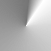

In [5]:
html

In [125]:
###

## Find Regex that matches consts
Regex taht matches "const <RANDOM> = {" and "};"

In [27]:
matches = re.finditer(r'const\s*\w*\s*=\s*\{.+?\};', script.text, re.DOTALL)

In [28]:
dict_matches = [re.sub(r'const\s*\w*\s*=\s*', '', match.group(0)).rstrip(";") for match in matches]

In [ ]:
concat_dicts = ",".join(dict_matches)

In [ ]:
with open('temp.js', 'w') as f:
    f.write('const teslaData = [' + concat_dicts + '];\nprocess.stdout.write(JSON.stringify(teslaData));')

In [ ]:
window_init_state = check_output(['node','temp.js'])

In [ ]:
teslaData = json.loads(window_init_state.decode())

In [ ]:
with open('tesla_modely.json', 'w') as f:
    json.dump(teslaData, f)

In [31]:
def getTeslaModelJSON(script):
    matches = re.finditer(r'const\s*\w*\s*=\s*\{.+?\};', script.text, re.DOTALL)
    dict_matches = [re.sub(r'const\s*\w*\s*=\s*', '', match.group(0)).rstrip(";") for match in matches]
    concat_dicts = ",".join(dict_matches)
    js_export_json_string = 'const teslaData = [' + concat_dicts + '];\nprocess.stdout.write(JSON.stringify(teslaData));'
    with open('temp.js', 'w') as f:
        f.write(js_export_json_string)
    modelData = json.loads(check_output(['node','temp.js']).decode())
    with open('tesla_modely.json', 'w') as f:
        json.dump(modelData, f)

In [19]:
dict_matches = [re.sub(r'const\s*\w*\s*=\s*', '', match.group(0)).rstrip(";") for match in matches]

In [110]:
concat_dicts = ",".join(dict_matches)

In [113]:
with open('temp.js', 'w') as f:
    f.write('const teslaData = [' + concat_dicts + '];\nprocess.stdout.write(JSON.stringify(teslaData));')

In [114]:
window_init_state = check_output(['node','temp.js'])

In [122]:
teslaData = json.loads(window_init_state.decode())

In [123]:
with open('tesla_modely.json', 'w') as f:
    json.dump(teslaData, f)